### Objective: To Train initial linear and logistic regressors.

Below, I train some linear models (linear and logistic regression) for regression and classification task. I first train models on the individual descriptors (features) and then train a multivariate model on each. I only use L1 regularization. But I should explore L2 regularization as well. 

I do 10x 5 fold cross validation. 


Note: I have modified the featurization code (which resulted in a lot of sparsity). In this notebook, I am using the recalculated features. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq3
from tqdm.notebook import tqdm
import numpy as np
import plotly.express as px
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV, cross_validate, RepeatedKFold, RepeatedStratifiedKFold, KFold
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

##### Load the data of interest 

In [3]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)
descriptors_fname = data_path/'MPK190_descriptors_V13_heparin_column.pq'
descriptors_df = pd.read_parquet(descriptors_fname)
metadata = data_path/'MPK190-v13-metadata.pq'
metadata_df =pd.read_parquet(metadata)

In [4]:
len(metadata_df)

69

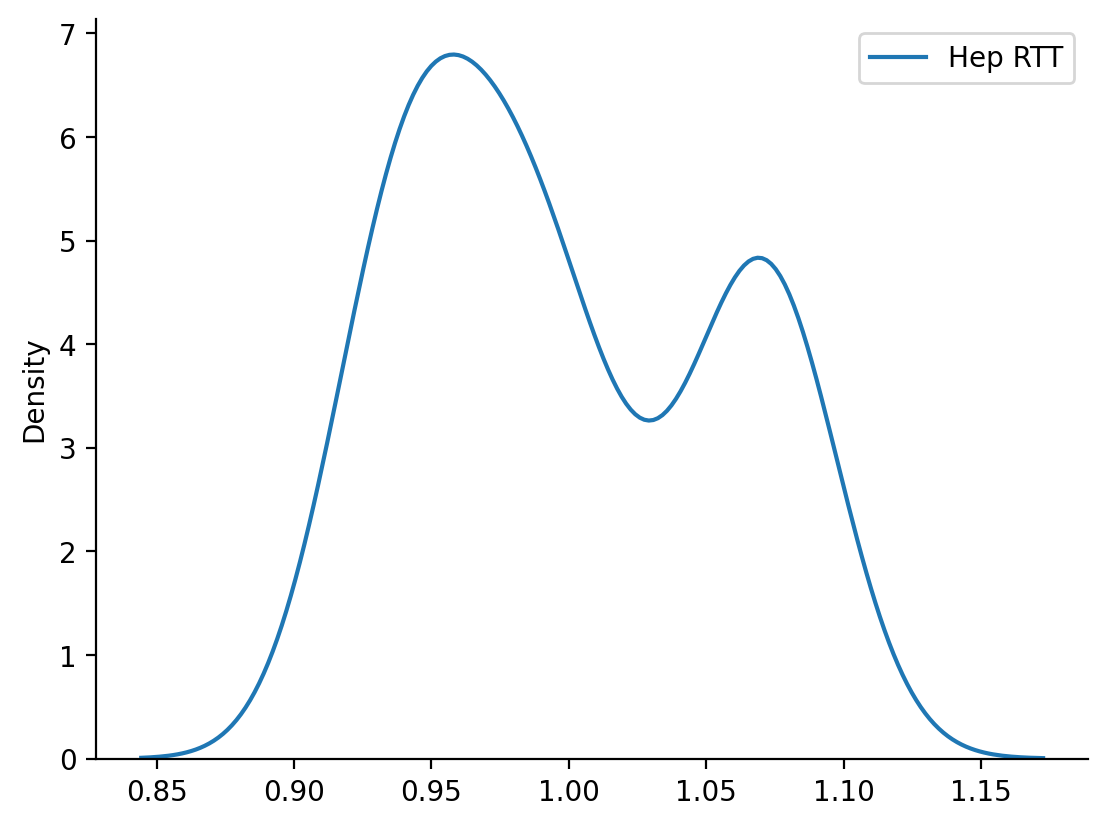

In [5]:
assert (metadata_df.index==descriptors_df.index).mean()==1
heparin = metadata_df[['Hep RTT']]
sns.kdeplot(heparin)
sns.despine()

##### Remove columns with all zeros. 

In [6]:
mean_zeros = (descriptors_df==0).mean()
cols = mean_zeros.index[mean_zeros<1]
descriptors_df = descriptors_df[cols]

##### Split data into train test. 
This is a small dataset. We will have a very small holdout set. 

In [7]:
heparin['Label'] = heparin['Hep RTT']>1.0
X_train, X_test, y_train, y_test = train_test_split(descriptors_df, heparin, shuffle=True, stratify=heparin['Label'], train_size = 60, random_state =42)
distribution = pd.concat([y_train.mean(), y_test.mean()], axis = 1)
distribution.columns = ['Train', 'Test']
distribution

Train      Test
Hep RTT  0.9974  1.006333
Label    0.4000  0.444444

##### Perform Univariate Regressions
For this we, don't need to do any feature scaling, because its univariate. If we want to compare coefficients easily we would. But these are just baseline dumb models. 


In [8]:
def cross_validate_single_descriptor(descriptor,  model, scoring, y_col='Hep RTT', cv = 10):
    
    cv = RepeatedStratifiedKFold(random_state=42) if y_col=='Label' else RepeatedKFold(random_state=42)

    model = model()
    x = X_train[descriptor].values.reshape(-1,1)
    y = y_train[y_col].values.reshape(-1,1)
    scores = cross_validate(model, X=x, y=y, cv=cv, scoring=scoring, return_train_score=True)
    
    scores = pd.DataFrame.from_dict(scores)
    scores.index = [descriptor]*len(scores)
    return scores


def drop_zeros(s):
    """ drop zeros from series
    Args:
        s (pd.Series): 
    Returns:
        pd.Series: 
    """
    return s[s!=0]


In [9]:
scores= []
for col in tqdm(descriptors_df.columns):
    scores.append(cross_validate_single_descriptor(col, LinearRegression, scoring = ['neg_root_mean_squared_error','r2']))
scores_df = pd.concat(scores)
scores_df = (np.abs(scores_df)
             .reset_index()
             .rename({'test_neg_root_mean_squared_error':'test_root_mean_squared_error',
                      'train_neg_root_mean_squared_error':'train_root_mean_squared_error',
                      'index':'Descriptor'
                      }, axis = 1
                      )
             
             )
scores_df.head()

  0%|          | 0/67 [00:00<?, ?it/s]

Descriptor  fit_time  score_time  test_root_mean_squared_error  \
0  HCDR1_APBS_pos  0.001356    0.000581                      0.029966   
1  HCDR1_APBS_pos  0.000358    0.000453                      0.024045   
2  HCDR1_APBS_pos  0.000410    0.000347                      0.044939   
3  HCDR1_APBS_pos  0.000342    0.000400                      0.031722   
4  HCDR1_APBS_pos  0.000221    0.000265                      0.024852   

   train_root_mean_squared_error   test_r2  train_r2  
0                       0.030932  0.583618  0.685197  
1                       0.032213  0.752928  0.655389  
2                       0.026249  0.280503  0.759477  
3                       0.030320  0.607346  0.692026  
4                       0.032142  0.845308  0.599333

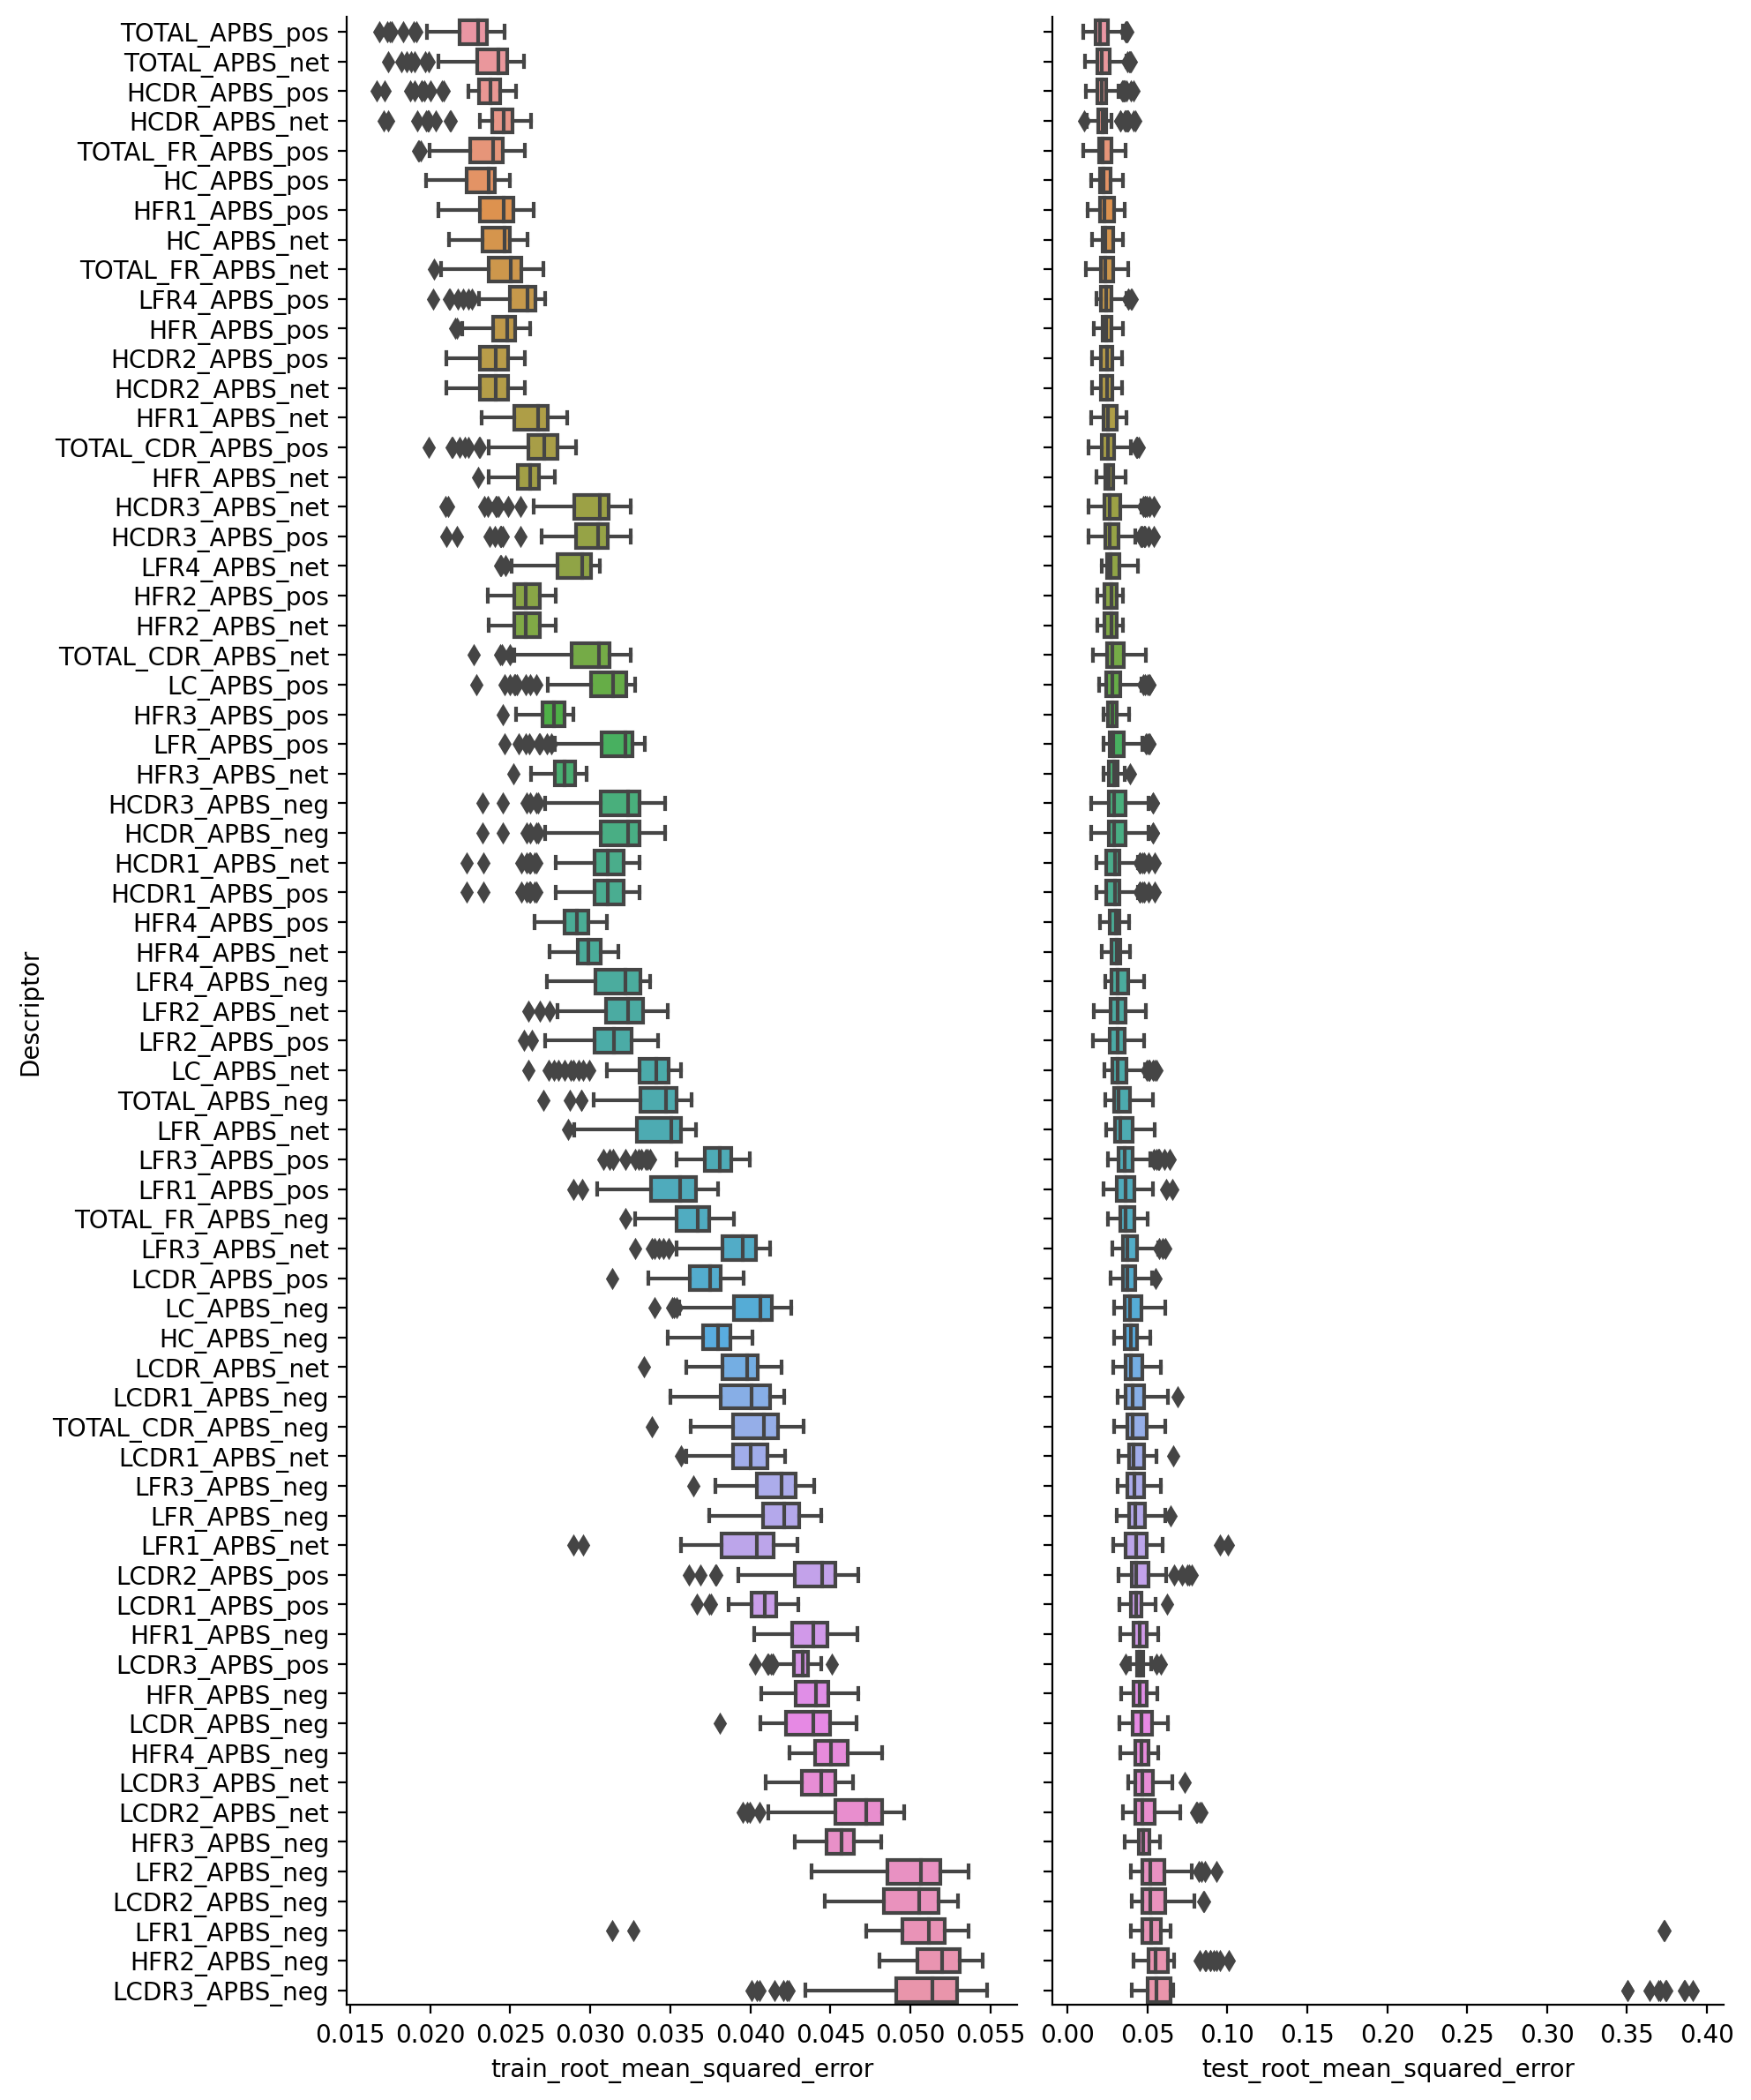

In [13]:

fig, axes = plt.subplots(1,2, figsize = (10,12))
order = scores_df.groupby('Descriptor')['test_root_mean_squared_error'].median().sort_values().index

sns.boxplot(data =scores_df, y = 'Descriptor', x = 'train_root_mean_squared_error' , order = order, ax = axes[0])
ax=sns.boxplot(data =scores_df, y = 'Descriptor', x = 'test_root_mean_squared_error' , order = order, ax =axes[1])
ax.set(yticklabels=[], ylabel = "")
ax.tick_params(axis='y', labelsize = 8)
sns.despine()
plt.tight_layout()

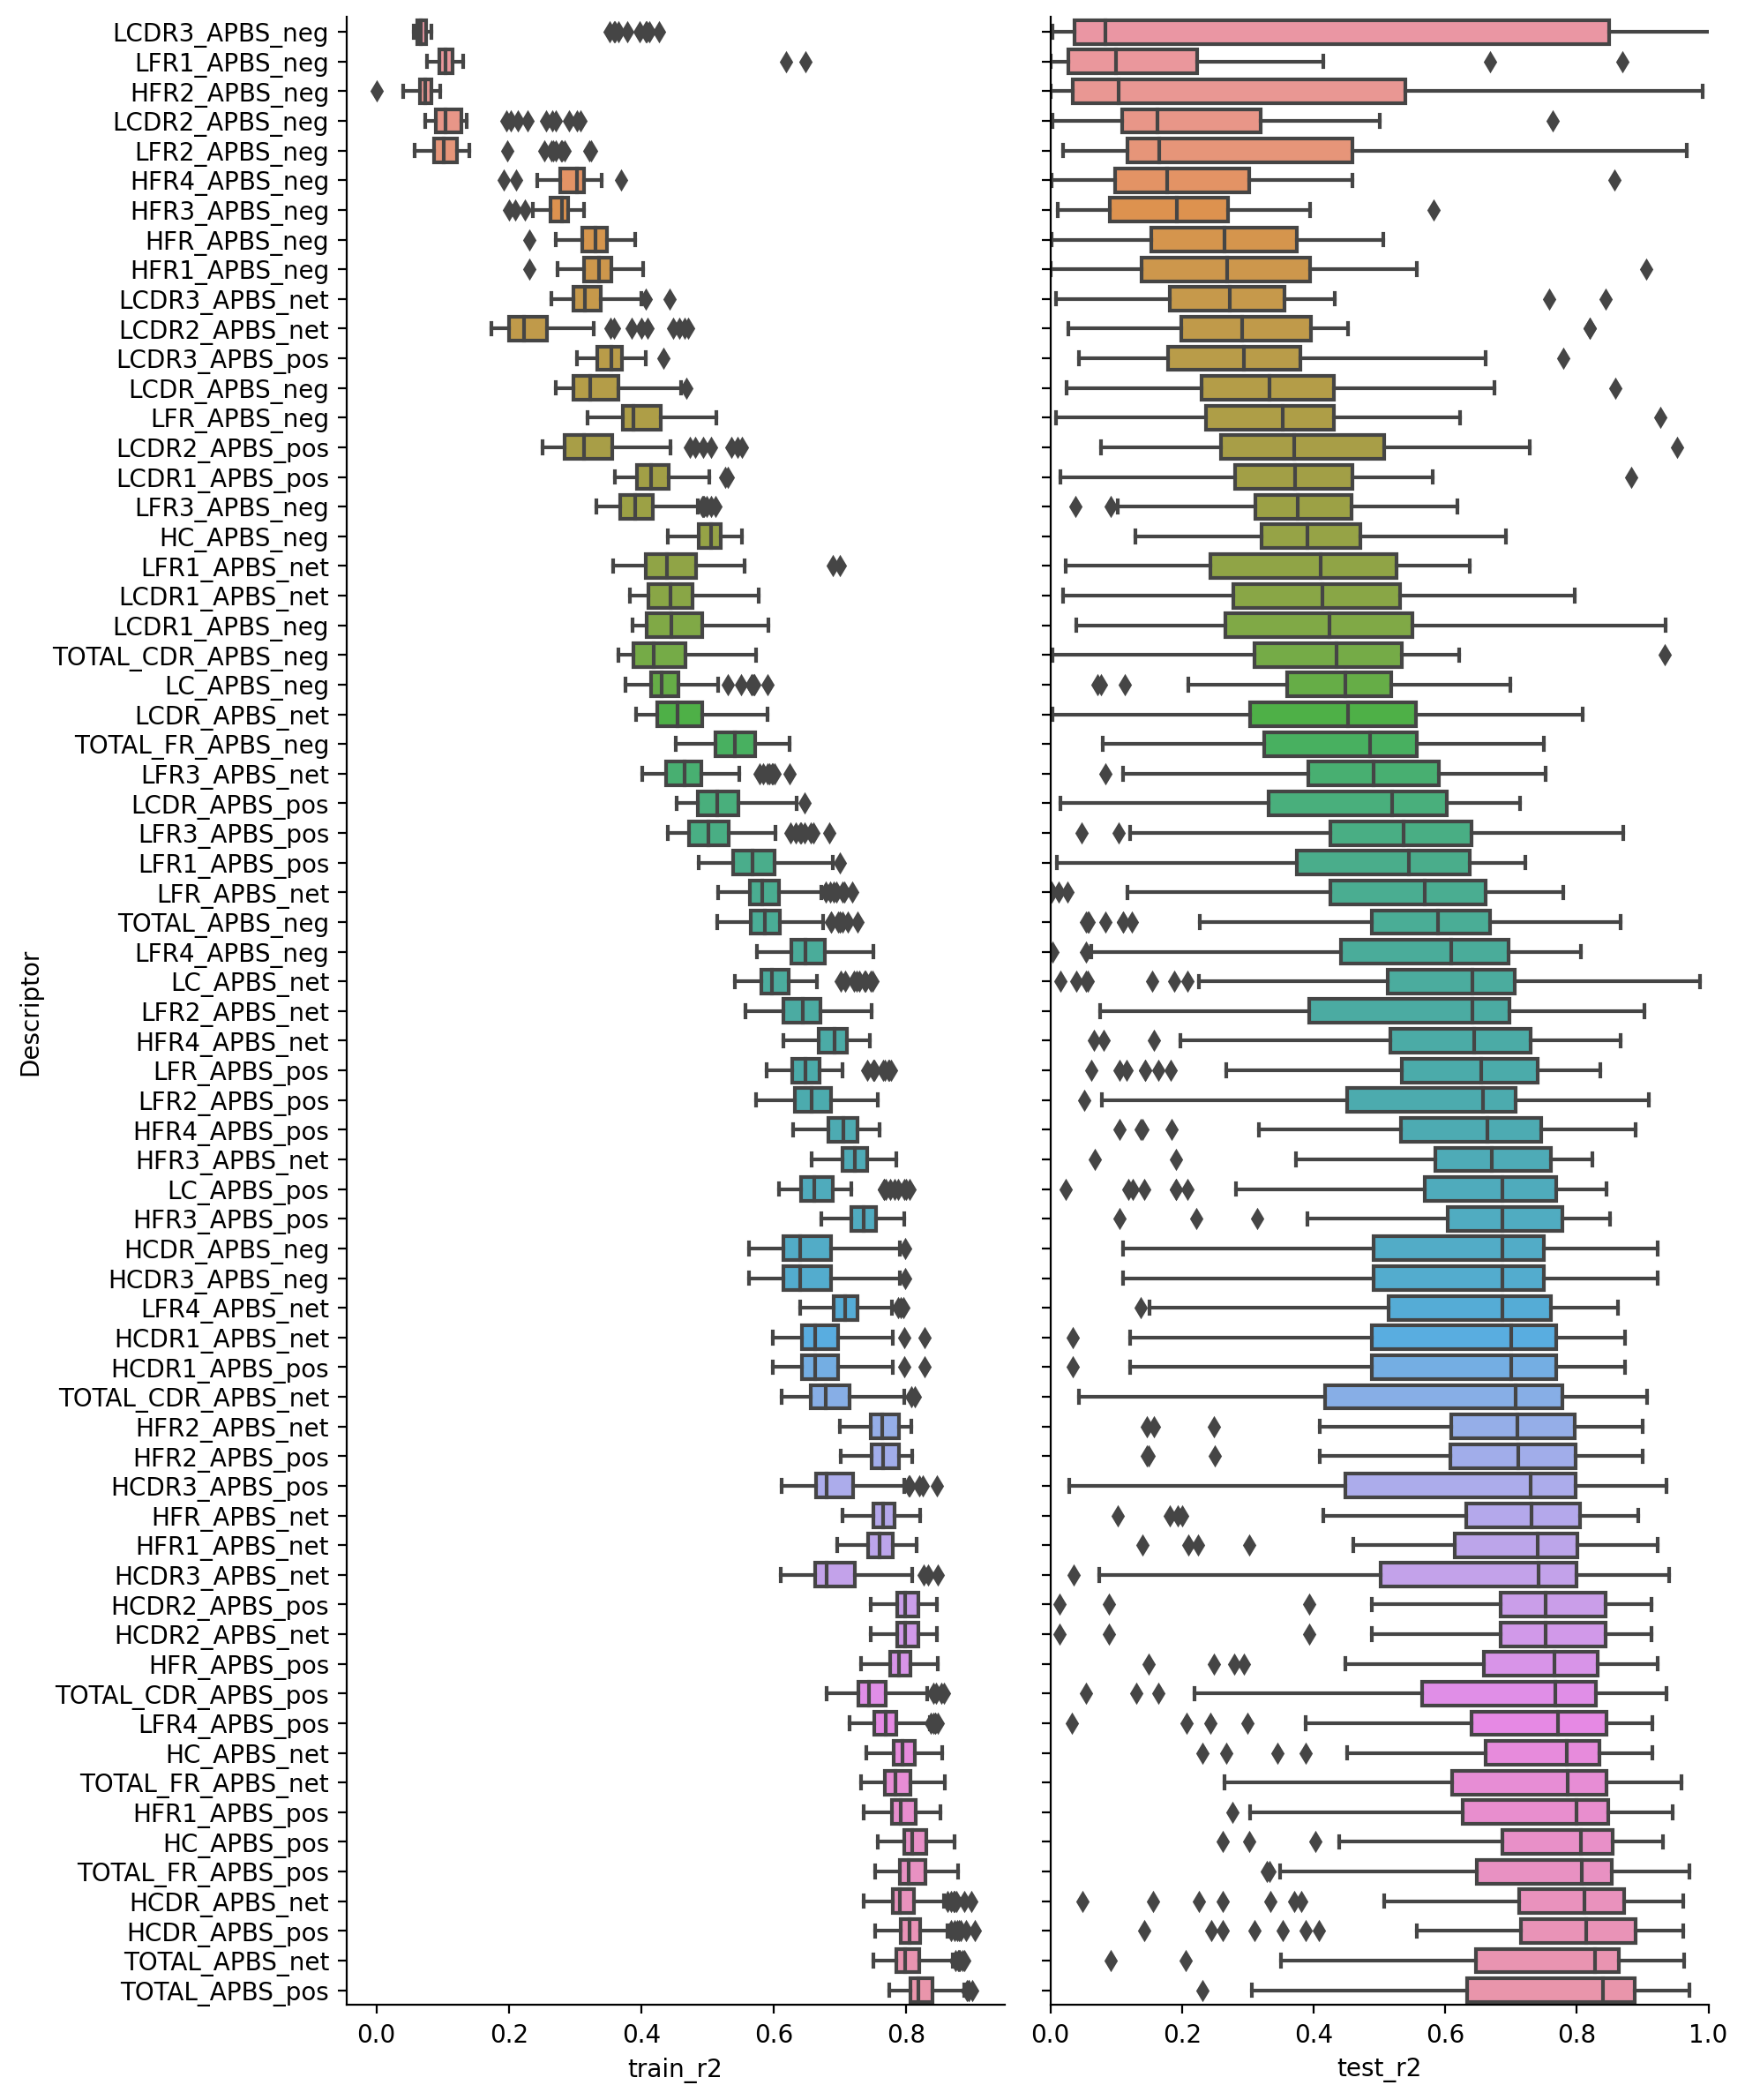

In [12]:

fig, axes = plt.subplots(1,2, figsize = (10, 12))
order = scores_df.groupby('Descriptor')['test_r2'].median().sort_values().index

sns.boxplot(data =scores_df, y = 'Descriptor', x = 'train_r2' , order = order, ax = axes[0])
ax=sns.boxplot(data =scores_df, y = 'Descriptor', x = 'test_r2' , order = order, ax =axes[1])
ax.set(yticklabels=[], ylabel = "", xlim = (0,1))
ax.tick_params(axis='y', labelsize = 8)
sns.despine()
plt.tight_layout()

In [14]:
cols = ['test_root_mean_squared_error','test_r2']
single_variate_lasso_mean_scores_df = (scores_df 
                                      .groupby('Descriptor')
                                      [cols]
                                      .agg(['mean','std', 'median'])
                                      .sort_values(('test_root_mean_squared_error', 'mean'))                                      )
np.round(single_variate_lasso_mean_scores_df.head(5),3)

test_root_mean_squared_error               test_r2         \
                                          mean    std median    mean    std   
Descriptor                                                                    
TOTAL_APBS_pos                           0.022  0.007  0.020   0.762  0.186   
HCDR_APBS_pos                            0.023  0.007  0.022   0.744  0.207   
TOTAL_APBS_net                           0.023  0.007  0.021   0.737  0.208   
HC_APBS_pos                              0.023  0.005  0.022   0.745  0.168   
TOTAL_FR_APBS_pos                        0.023  0.006  0.022   0.738  0.183   

                          
                  median  
Descriptor                
TOTAL_APBS_pos     0.840  
HCDR_APBS_pos      0.814  
TOTAL_APBS_net     0.828  
HC_APBS_pos        0.806  
TOTAL_FR_APBS_pos  0.807

#### Fit a regression model with all of the features using L1 regularization 

In [15]:
pipes = Pipeline([('scaler', StandardScaler()), 
                  ('lasso', Lasso())])

cv =  RepeatedKFold(random_state=42)

search = GridSearchCV(pipes, param_grid = {'lasso__alpha':np.logspace(start =-4, stop = 2)}, cv = cv, refit ='neg_root_mean_squared_error', return_train_score = True,scoring=['neg_root_mean_squared_error','r2'])
search.fit(X_train, y_train[['Hep RTT']])

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04, 7.19685673e-04,
       9.54095476e-04, 1.26485522e-03, 1.67683294e-03, 2.2229...
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error', 'r2'])

In [16]:
results = (pd.DataFrame(search.cv_results_)
          .sort_values('mean_test_neg_root_mean_squared_error', ascending = False)
           )
        
cols = [col for col in results.columns if col.startswith('mean') or col.startswith('param') or 'rank' in col]
results[cols].head()

mean_fit_time  mean_score_time param_lasso__alpha  \
8       0.001764         0.001012           0.000954   
7       0.001862         0.001005            0.00072   
9       0.001784         0.001024           0.001265   
6       0.002002         0.001013           0.000543   
5       0.002185         0.001005           0.000409   

                                     params  \
8   {'lasso__alpha': 0.0009540954763499944}   
7   {'lasso__alpha': 0.0007196856730011522}   
9   {'lasso__alpha': 0.0012648552168552957}   
6   {'lasso__alpha': 0.0005428675439323859}   
5  {'lasso__alpha': 0.00040949150623804275}   

   mean_test_neg_root_mean_squared_error  \
8                              -0.019266   
7                              -0.019320   
9                              -0.019362   
6                              -0.019419   
5                              -0.019704   

   rank_test_neg_root_mean_squared_error  \
8                                      1   
7                                      2   
9                                      3   
6                                      4   
5                                      5   

   mean_train_neg_root_mean_squared_error  mean_test_r2  rank_test_r2  \
8                               -0.015180      0.828374             1   
7                               -0.014926      0.827368             2   
9                               -0.015495      0.824168             3   
6                               -0.014331      0.821687             4   
5                               -0.013614      0.810329             6   

   mean_train_r2  
8       0.919405  
7       0.922047  
9       0.916086  
6       0.928174  
5       0.935279

In [17]:
def organize_search_results(results, param):
    """ organize grid search results into long format"""

    def format_subset(dataset): 
        cols = [col for col in results.columns if 'split' in col and dataset in col]
        col_dict = {}
        for col in cols: 
            metric = col.split(f'{dataset}_')[1]
            col_dict.setdefault(metric,[])
            col_dict[metric].append(col)

        dfs = []
        for metric, cols in col_dict.items():
            
            df = (results.melt(id_vars = param, value_vars=cols)
                  .drop('variable', axis = 1)
                  .rename({'value': metric}, axis = 1)
                  .set_index(param)
            )
            dfs.append(df)
        df= pd.concat(dfs,axis = 1)
        df.insert(0,'dataset', dataset)
        return df

    test_df = format_subset('test')
    train_df = format_subset('train')
    return (pd.concat([test_df, train_df])
            .reset_index()
            .sort_values(['dataset', param])
            )     

In [18]:
long_scores_df= organize_search_results(results, 'param_lasso__alpha')
long_scores_df.head()



param_lasso__alpha dataset  neg_root_mean_squared_error        r2
16               0.0001    test                    -0.063950 -0.896363
66               0.0001    test                    -0.021252  0.806989
116              0.0001    test                    -0.025003  0.777284
166              0.0001    test                    -0.025220  0.751822
216              0.0001    test                    -0.014119  0.950072

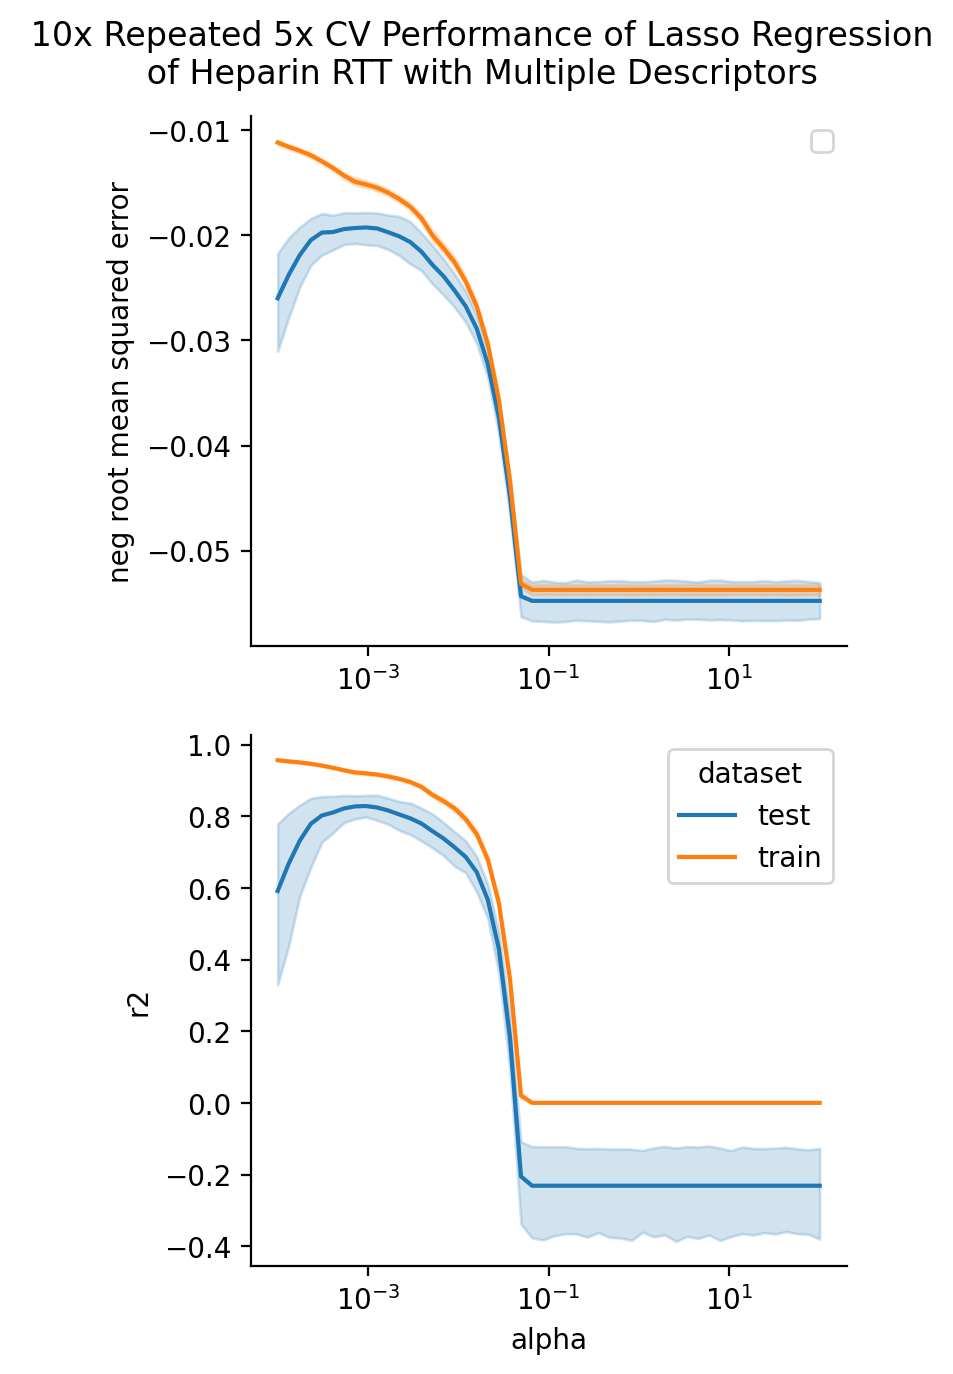

In [19]:

fig, axes = plt.subplots(2,1, figsize = (4,7))
axes = np.ravel( axes)
ax = sns.lineplot(data = long_scores_df, x='param_lasso__alpha', y= 'neg_root_mean_squared_error', hue = 'dataset', ax =axes[0])
ax.set(xscale='log', xlabel = '',ylabel = 'neg_root_mean_squared_error'.replace('_', ' '))
ax.legend('')

ax = sns.lineplot(data = long_scores_df, x='param_lasso__alpha', y= 'r2', hue = 'dataset', ax = axes[1])
ax.set(xscale='log', xlabel = 'alpha')
fig.suptitle(' 10x Repeated 5x CV Performance of Lasso Regression\n of Heparin RTT with Multiple Descriptors')
sns.despine()
fig.tight_layout()

#### Evaluate the feature importance of the final model

In [20]:
search.best_params_
estimator = search.best_estimator_
coefs = pd.Series(estimator.steps[1][1].coef_, index = X_train.columns)


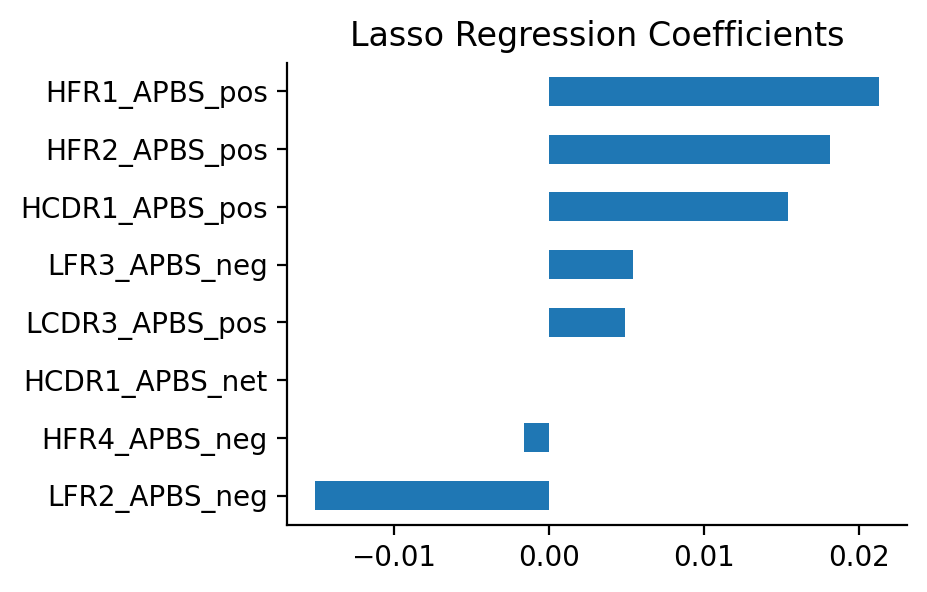

In [21]:

ax = drop_zeros(coefs.sort_values()).plot(kind = 'barh', figsize = (4,3))
ax.set( title = 'Lasso Regression Coefficients')
sns.despine()

In [22]:
y_pred = search.predict(X_train)
resid = (y_pred - y_train['Hep RTT']).values
y_vals = (pd.DataFrame(dict( y_train = y_train['Hep RTT'], y_pred =y_pred, resid = resid))
          .sort_values('y_pred'))
y_vals.head()

y_train    y_pred     resid
Name                                              
VIRMAB-ML-M190-R2-078    0.924  0.907162 -0.016838
VIRMAB-ML-M190-R2-106    0.916  0.918863  0.002863
VIRMAB-ML-M190-R2-060    0.923  0.928010  0.005010
VIRMAB-ML-M190-R2-029    0.942  0.937114 -0.004886
VIRMAB-ML-M190-R2-068    0.933  0.937711  0.004711

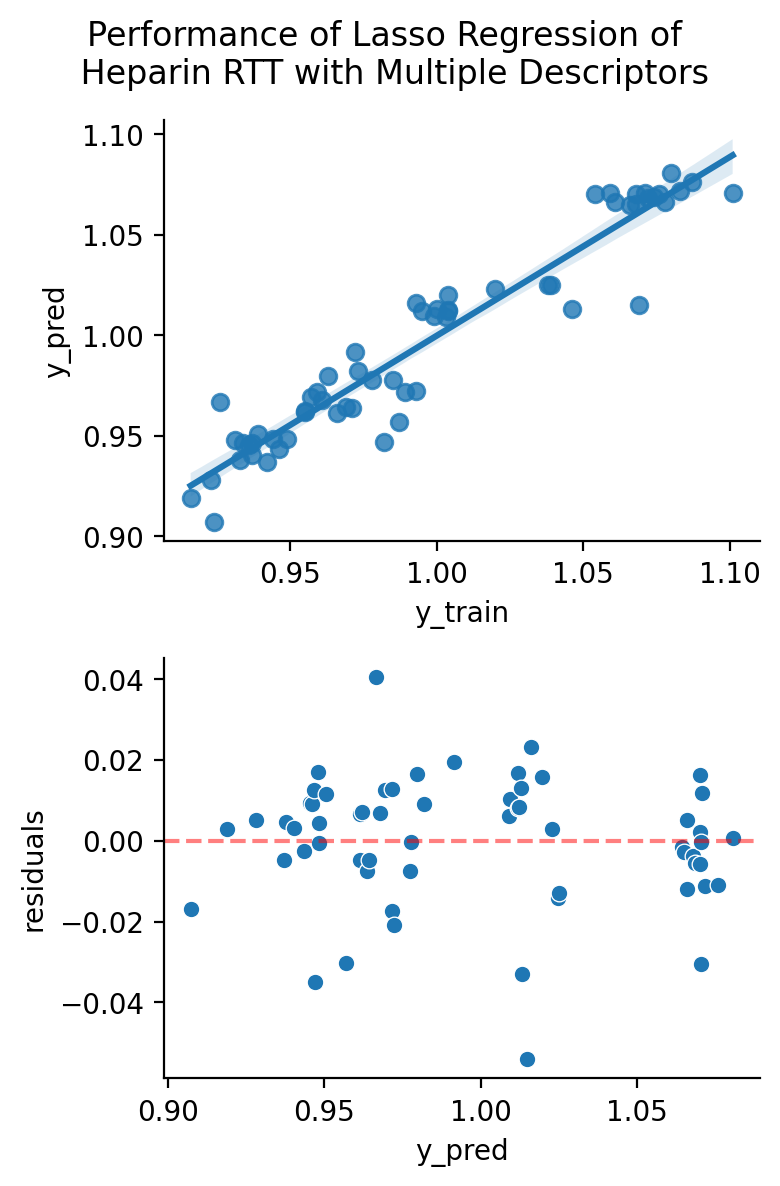

In [23]:
fig, axes = plt.subplots(2,1, figsize = (4,6))
axes = np.ravel(axes)

ax = sns.regplot(data = y_vals, x='y_train', y = 'y_pred', ax = axes[0])
ax.set(ylabel='y_pred')

sns.scatterplot(data = y_vals, x='y_pred', y = 'resid', ax = axes[1])
ax = plt.gca()
ax.axhline(0, color = 'red', linestyle = '--', alpha = 0.5)
ax.set(xlabel = 'y_pred', ylabel= 'residuals')

sns.despine()
fig.suptitle('Performance of Lasso Regression of \n Heparin RTT with Multiple Descriptors')
fig.tight_layout()

### Now fit Logistic regressions for classification 

In [24]:
scores= []
for col in tqdm(descriptors_df.columns):
    scores.append(cross_validate_single_descriptor(col,model = LogisticRegression, scoring = ['accuracy','recall', 'precision', 'f1', 'roc_auc'], y_col= 'Label'))
scores_df = pd.concat(scores)
scores_df = (np.abs(scores_df)
             .reset_index()
             .rename({'index':'Descriptor'}, axis = 1)
             )
             
scores_df.head()

  0%|          | 0/67 [00:00<?, ?it/s]

Descriptor  fit_time  score_time  test_accuracy  train_accuracy  \
0  HCDR1_APBS_pos  0.006723    0.003555       0.750000        0.916667   
1  HCDR1_APBS_pos  0.001761    0.004814       0.833333        0.895833   
2  HCDR1_APBS_pos  0.002102    0.002796       0.916667        0.875000   
3  HCDR1_APBS_pos  0.001900    0.003858       1.000000        0.854167   
4  HCDR1_APBS_pos  0.001359    0.003561       0.916667        0.875000   

   test_recall  train_recall  test_precision  train_precision   test_f1  \
0          0.6      0.842105            0.75         0.941176  0.666667   
1          0.6      0.842105            1.00         0.888889  0.750000   
2          0.8      0.789474            1.00         0.882353  0.888889   
3          1.0      0.736842            1.00         0.875000  1.000000   
4          1.0      0.750000            0.80         0.937500  0.888889   

   train_f1  test_roc_auc  train_roc_auc  
0  0.888889      0.885714       0.947368  
1  0.864865      0.828571       0.981851  
2  0.833333      1.000000       0.936479  
3  0.800000      1.000000       0.925590  
4  0.833333      1.000000       0.935714

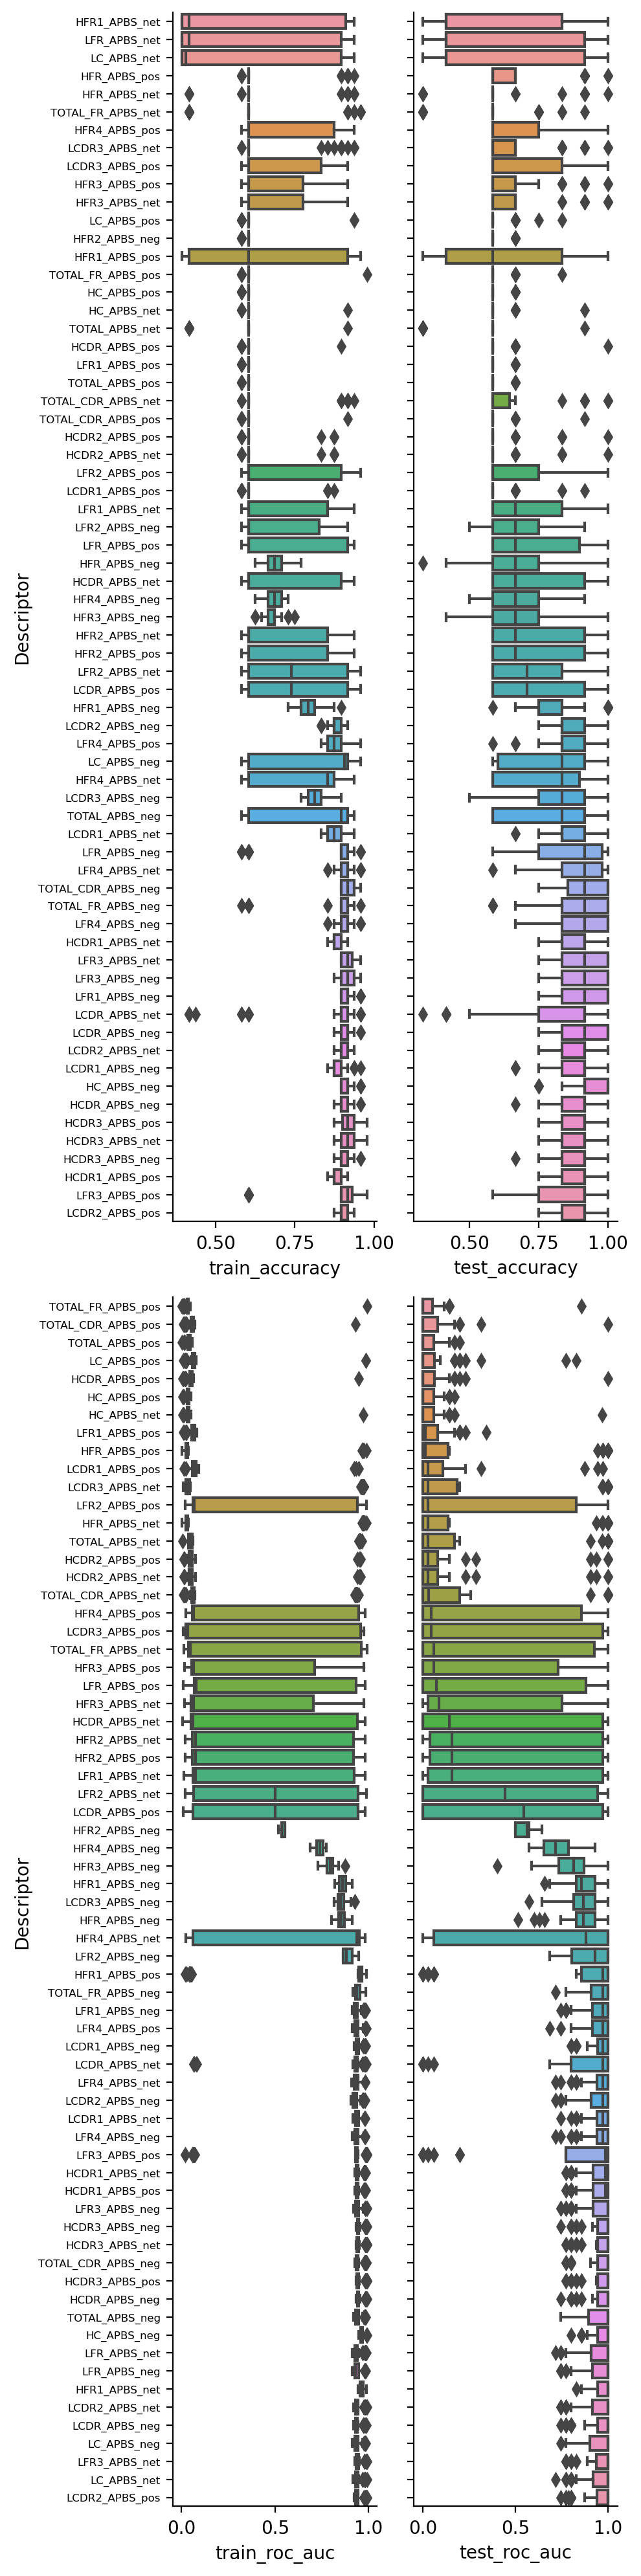

In [33]:
metrics = ['accuracy', 'roc_auc']


fig, axes = plt.subplots(2,2, figsize = (5, 20))
axes = np.ravel(axes)
for i,metric in enumerate(metrics): 
    order = scores_df.groupby('Descriptor')[f'test_{metric}'].median().sort_values().index

    ax=sns.boxplot(data =scores_df, y = 'Descriptor', x = f'train_{metric}' , order = order, ax = axes[2*i])
    ax.tick_params(axis='y', labelsize = 6)
    ax=sns.boxplot(data =scores_df, y = 'Descriptor', x = f'test_{metric}' , order = order, ax =axes[2*i+1])
    ax.set(yticklabels=[], ylabel = "")
    ax.tick_params(axis='y', labelsize = 6)

sns.despine()
plt.tight_layout()

##### Aggregate Scores for each descriptor CV

In [34]:
cols = ['test_roc_auc','test_accuracy', 'test_recall', 'test_f1','test_precision']
single_variate_logistic_mean_scores_df = (scores_df 
                                      .groupby('Descriptor')
                                      [cols]
                                      .agg(['mean','std', 'median'])
                                      .sort_values(('test_roc_auc', 'mean'), ascending = False)                                      )
np.round(single_variate_logistic_mean_scores_df.head(10),3)

test_roc_auc               test_accuracy                \
                           mean    std median          mean    std median   
Descriptor                                                                  
HFR1_APBS_net             0.966  0.048  1.000         0.617  0.254  0.417   
HC_APBS_neg               0.965  0.050  1.000         0.920  0.071  0.917   
LCDR1_APBS_neg            0.954  0.065  0.971         0.887  0.092  0.917   
HCDR3_APBS_net            0.953  0.076  1.000         0.893  0.065  0.917   
HCDR3_APBS_pos            0.953  0.076  1.000         0.887  0.079  0.917   
HCDR3_APBS_neg            0.951  0.077  1.000         0.892  0.076  0.917   
HCDR_APBS_neg             0.951  0.077  1.000         0.892  0.076  0.917   
LCDR1_APBS_net            0.949  0.065  0.971         0.863  0.082  0.833   
TOTAL_CDR_APBS_neg        0.948  0.081  1.000         0.918  0.070  0.917   
TOTAL_FR_APBS_neg         0.948  0.071  0.971         0.877  0.130  0.917   

                   test_recall               test_f1                \
                          mean    std median    mean    std median   
Descriptor                                                           
HFR1_APBS_net            0.906  0.166    1.0   0.689  0.161  0.588   
HC_APBS_neg              0.952  0.103    1.0   0.906  0.081  0.909   
LCDR1_APBS_neg           0.948  0.120    1.0   0.873  0.099  0.889   
HCDR3_APBS_net           0.869  0.160    1.0   0.863  0.086  0.889   
HCDR3_APBS_pos           0.846  0.194    1.0   0.848  0.115  0.889   
HCDR3_APBS_neg           0.849  0.160    0.8   0.860  0.096  0.889   
HCDR_APBS_neg            0.849  0.160    0.8   0.860  0.096  0.889   
LCDR1_APBS_net           0.875  0.157    1.0   0.836  0.095  0.833   
TOTAL_CDR_APBS_neg       0.956  0.093    1.0   0.906  0.078  0.909   
TOTAL_FR_APBS_neg        0.828  0.336    1.0   0.787  0.314  0.899   

                   test_precision                
                             mean    std median  
Descriptor                                       
HFR1_APBS_net               0.638  0.282  0.417  
HC_APBS_neg                 0.881  0.122  0.833  
LCDR1_APBS_neg              0.831  0.143  0.833  
HCDR3_APBS_net              0.895  0.124  1.000  
HCDR3_APBS_pos              0.899  0.129  1.000  
HCDR3_APBS_neg              0.905  0.122  1.000  
HCDR_APBS_neg               0.905  0.122  1.000  
LCDR1_APBS_net              0.838  0.145  0.800  
TOTAL_CDR_APBS_neg          0.874  0.119  0.833  
TOTAL_FR_APBS_neg           0.771  0.309  0.833

### Fit a Multivariate Logistic Regression model. 

In [41]:
pipes = Pipeline([('scaler', StandardScaler()), 
                  ('logistic', LogisticRegression(penalty='l1', solver = 'liblinear'))])

metrics = ['accuracy', 'recall', 'f1', 'roc_auc','precision']

y = y_train[['Label']].values.reshape(len(y_train), )
cv = RepeatedStratifiedKFold(random_state=42)
search2 = GridSearchCV(pipes, param_grid = {'logistic__C':np.logspace(start =-4, stop = 2)}, cv = cv, refit ='roc_auc', return_train_score = True,scoring=metrics, n_jobs=-1)
search2.fit(X_train,y )

/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ChristopherRivera/micromamba/envs/surface/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/Christ

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([1.00000000e-04, 1.32571137e-04, 1.75751062e-04, 2.32995181e-04,
       3.08884360e-04, 4.09491506e-04, 5.42867544e-04,...
       8.28642773e-01, 1.09854114e+00, 1.45634848e+00, 1.93069773e+00,
       2.55954792e+00, 3.39322177e+00, 4.49843267e+00, 5.96362332e+00,
       7.90604321e+00, 1.04811313e+01, 1.38949549e+01, 1.84206997e+01,
       2.44205309e+01, 3.23745754e+01, 4.29193426e+01, 5.68986603e+01,
       7.54312006e+01, 1.00000000e+02])},
             refit='roc_auc', return_train_score=True,
             scoring=['accuracy', 'recall', 'f1', 'roc_auc', 'precision'])

In [42]:
results = pd.DataFrame(search2.cv_results_).sort_values('mean_test_roc_auc', ascending = False)
cols = [col for col in results.columns if col.startswith('mean') or col.startswith('param') or 'rank' in col]
results[cols].head()


mean_fit_time  mean_score_time param_logistic__C  \
49       0.003904         0.003352             100.0   
47       0.002961         0.003781          56.89866   
48       0.003928         0.003620         75.431201   
46       0.003021         0.003745         42.919343   
42       0.003153         0.006741         13.894955   

                                params  mean_test_accuracy  \
49              {'logistic__C': 100.0}            0.891667   
47  {'logistic__C': 56.89866029018293}            0.895000   
48  {'logistic__C': 75.43120063354607}            0.893333   
46  {'logistic__C': 42.91934260128778}            0.890000   
42  {'logistic__C': 13.89495494373136}            0.866667   

    rank_test_accuracy  mean_train_accuracy  mean_test_recall  \
49                  14             1.000000             0.889   
47                  11             1.000000             0.873   
48                  12             1.000000             0.885   
46                  16             1.000000             0.869   
42                  26             0.985833             0.830   

    rank_test_recall  mean_train_recall  mean_test_f1  rank_test_f1  \
49                13           1.000000      0.867008            14   
47                15           1.000000      0.867458            12   
48                14           1.000000      0.867391            13   
46                17           1.000000      0.861276            17   
42                26           0.988579      0.828991            26   

    mean_train_f1  mean_test_roc_auc  rank_test_roc_auc  mean_train_roc_auc  \
49       1.000000           0.972982                  1            1.000000   
47       1.000000           0.971839                  2            1.000000   
48       1.000000           0.971268                  3            1.000000   
46       1.000000           0.970696                  4            1.000000   
42       0.982514           0.970018                  5            0.999457   

    mean_test_precision  rank_test_precision  mean_train_precision  
49             0.875881                    5              1.000000  
47             0.888952                    1              1.000000  
48             0.881476                    3              1.000000  
46             0.881619                    2              1.000000  
42             0.865048                   26              0.977468

In [43]:
logistic_long_scores_df= organize_search_results(results, 'param_logistic__C')
logistic_long_scores_df.head()

param_logistic__C dataset  accuracy  recall   f1  roc_auc  precision
49              0.0001    test  0.583333     0.0  0.0      0.5        0.0
99              0.0001    test  0.583333     0.0  0.0      0.5        0.0
149             0.0001    test  0.583333     0.0  0.0      0.5        0.0
199             0.0001    test  0.583333     0.0  0.0      0.5        0.0
249             0.0001    test  0.666667     0.0  0.0      0.5        0.0

Text(0.5, 0.98, '5x Repeated 5x CV metrics for L1 logistic regression versus C')

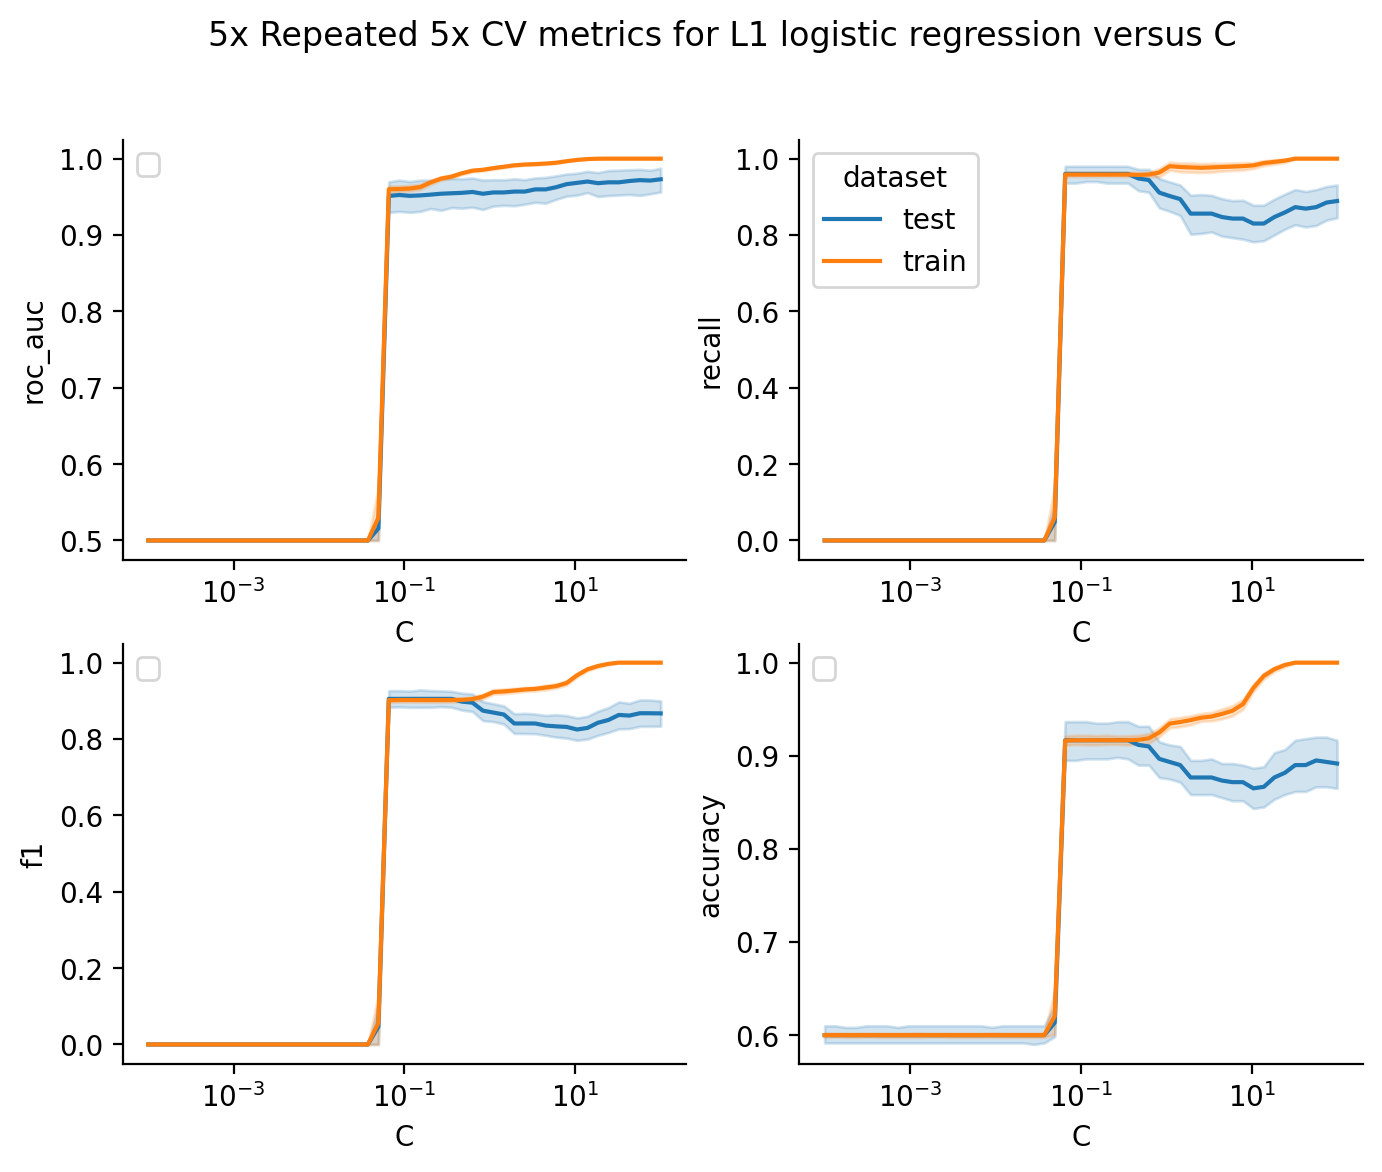

In [44]:
fig, axes = plt.subplots(2,2, figsize = (8,6))
axes = np.ravel(axes)
ax = sns.lineplot(data = logistic_long_scores_df, x='param_logistic__C', y= 'roc_auc', hue = 'dataset', ax =axes[0])
ax.set(xscale='log', xlabel = 'C')
ax.legend('')

ax = sns.lineplot(data = logistic_long_scores_df,  x='param_logistic__C', y= 'recall', hue = 'dataset', ax = axes[1])
ax.set(xscale='log', xlabel = 'C')

ax = sns.lineplot(data = logistic_long_scores_df, x='param_logistic__C', y= 'f1', hue = 'dataset', ax =axes[2])
ax.set(xscale='log', xlabel = 'C')
ax.legend('')

ax = sns.lineplot(data = logistic_long_scores_df,  x='param_logistic__C', y= 'accuracy', hue = 'dataset', ax = axes[3])
ax.set(xscale='log', xlabel = 'C')
ax.legend('')

sns.despine()
fig.suptitle('5x Repeated 5x CV metrics for L1 logistic regression versus C')

#### Look at coefficients. 

{'lasso__alpha': 0.0009540954763499944}


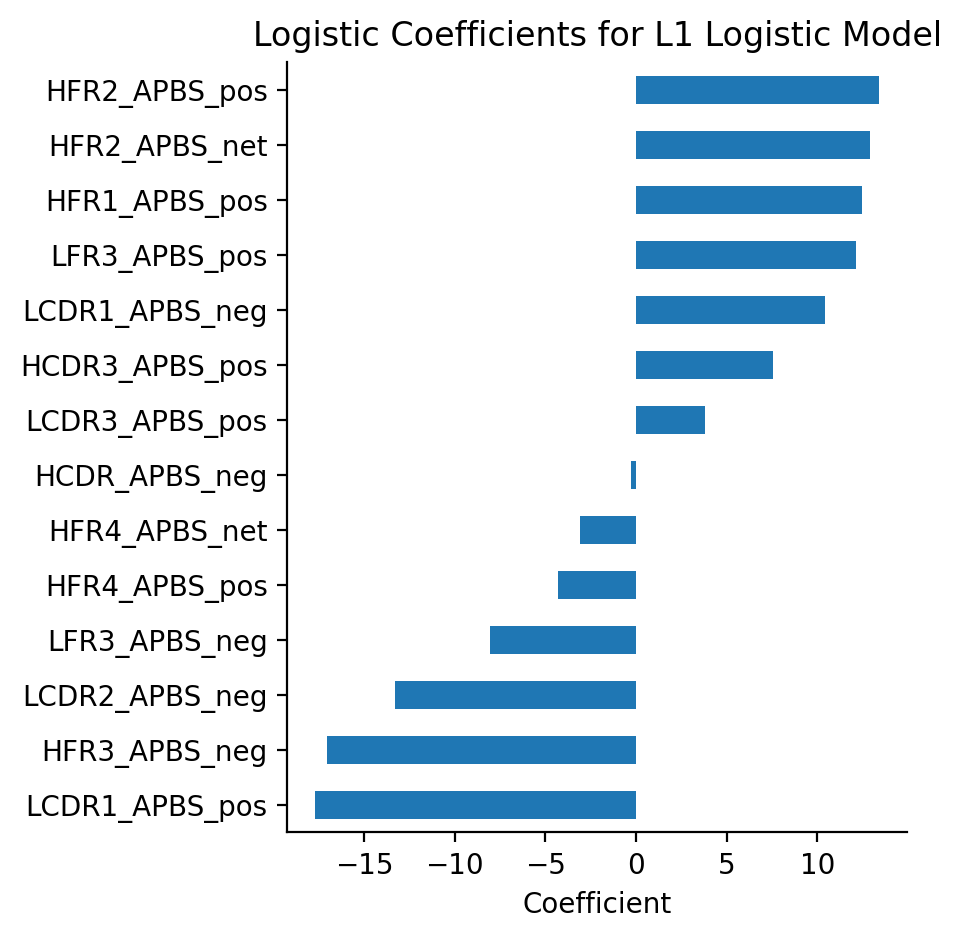

In [45]:



print(search.best_params_)
logistic = search2.best_estimator_
coefs = pd.Series(logistic.steps[1][1].coef_[0], index = X_train.columns)
ax = drop_zeros(coefs.sort_values()).plot(kind = 'barh', figsize = (4,5))
ax.set(xlabel = 'Coefficient', title='Logistic Coefficients for L1 Logistic Model')
sns.despine()

### ROC curve 

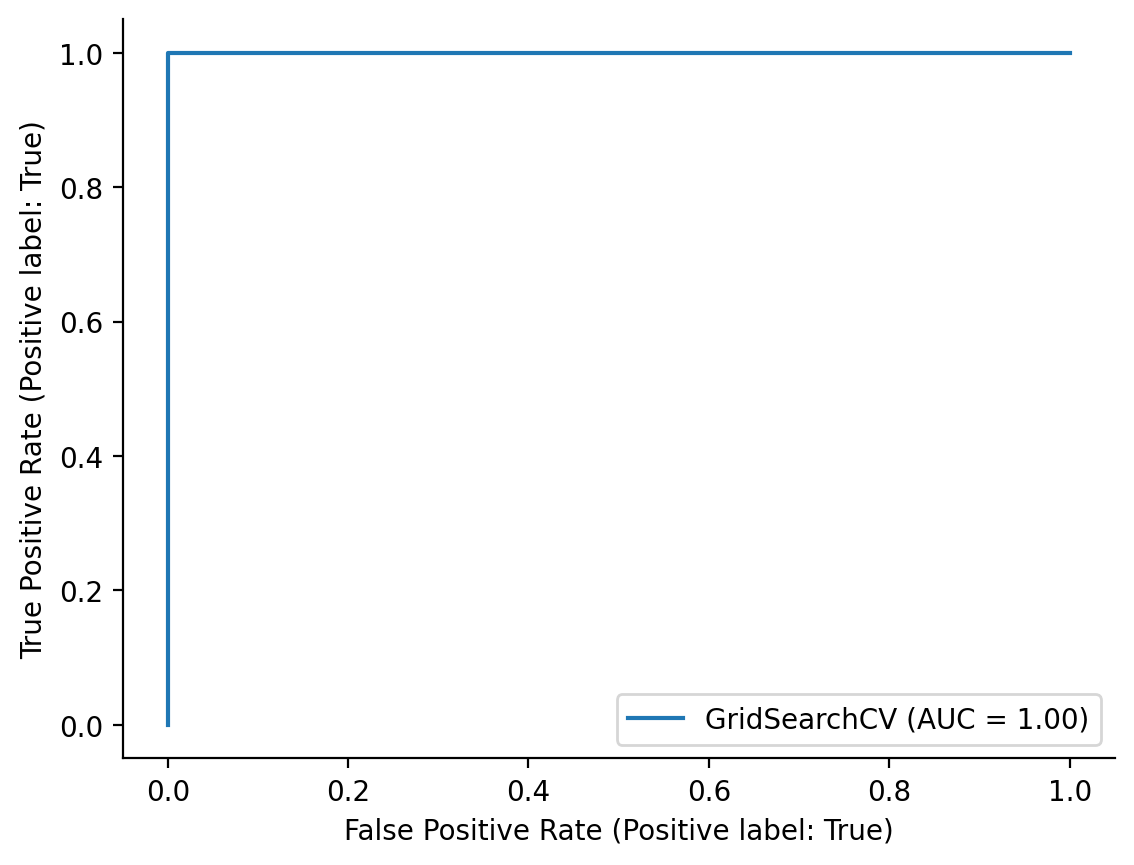

In [46]:
roc = RocCurveDisplay.from_estimator(search2, X_train, y_train['Label'])
sns.despine()


##### Remarks: 
Above, I trained some relatively simple Regressors (Lasso) and Classifiers ( L1 Logistic)
I get pretty great results for these models. I can try other models. 

#### Predict the CV test during cross validation. 

Cyrus wanted me to make a plot showing the test data for CV. To do this, I use the lasso trained above, redo 5x CV, and predict the cv test set. 

In [47]:
skf = KFold(n_splits = 5, shuffle = True, random_state=42)

y_true = []
y_preds = []


for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train['Hep RTT'])): 
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index]['Hep RTT'], y_train.iloc[test_index]['Hep RTT']
    # the estimator below is the best estimator from the grid search for Lasso
    estimator.fit(X_train_fold, y_train_fold)
    y_pred = estimator.predict(X_test_fold)

    y_true.extend(list(y_test_fold))
    y_preds.extend(list(y_pred))

y_val2 = pd.DataFrame(dict(y_train = y_true, y_pred = y_preds))
y_val2['residual'] = y_val2['y_pred'] - y_val2['y_train']




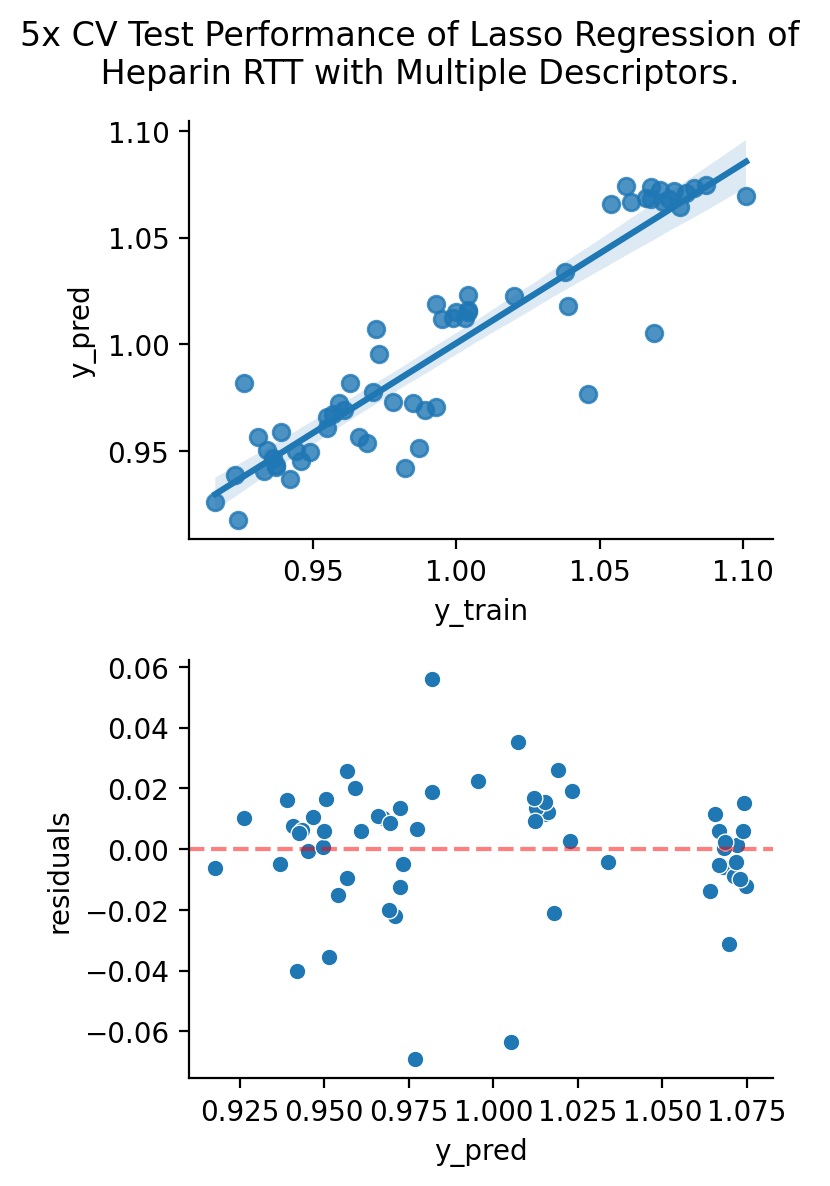

In [48]:
fig, axes = plt.subplots(2,1, figsize = (4,6))
axes = np.ravel(axes)

ax = sns.regplot(data = y_val2, x='y_train', y = 'y_pred', ax = axes[0])
ax.set(ylabel='y_pred')

sns.scatterplot(data = y_val2, x='y_pred', y = 'residual', ax = axes[1])
ax = plt.gca()
ax.axhline(0, color = 'red', linestyle = '--', alpha = 0.5)
ax.set(xlabel = 'y_pred', ylabel= 'residuals')

sns.despine()
fig.suptitle('5x CV Test Performance of Lasso Regression of \n Heparin RTT with Multiple Descriptors.')
fig.tight_layout()

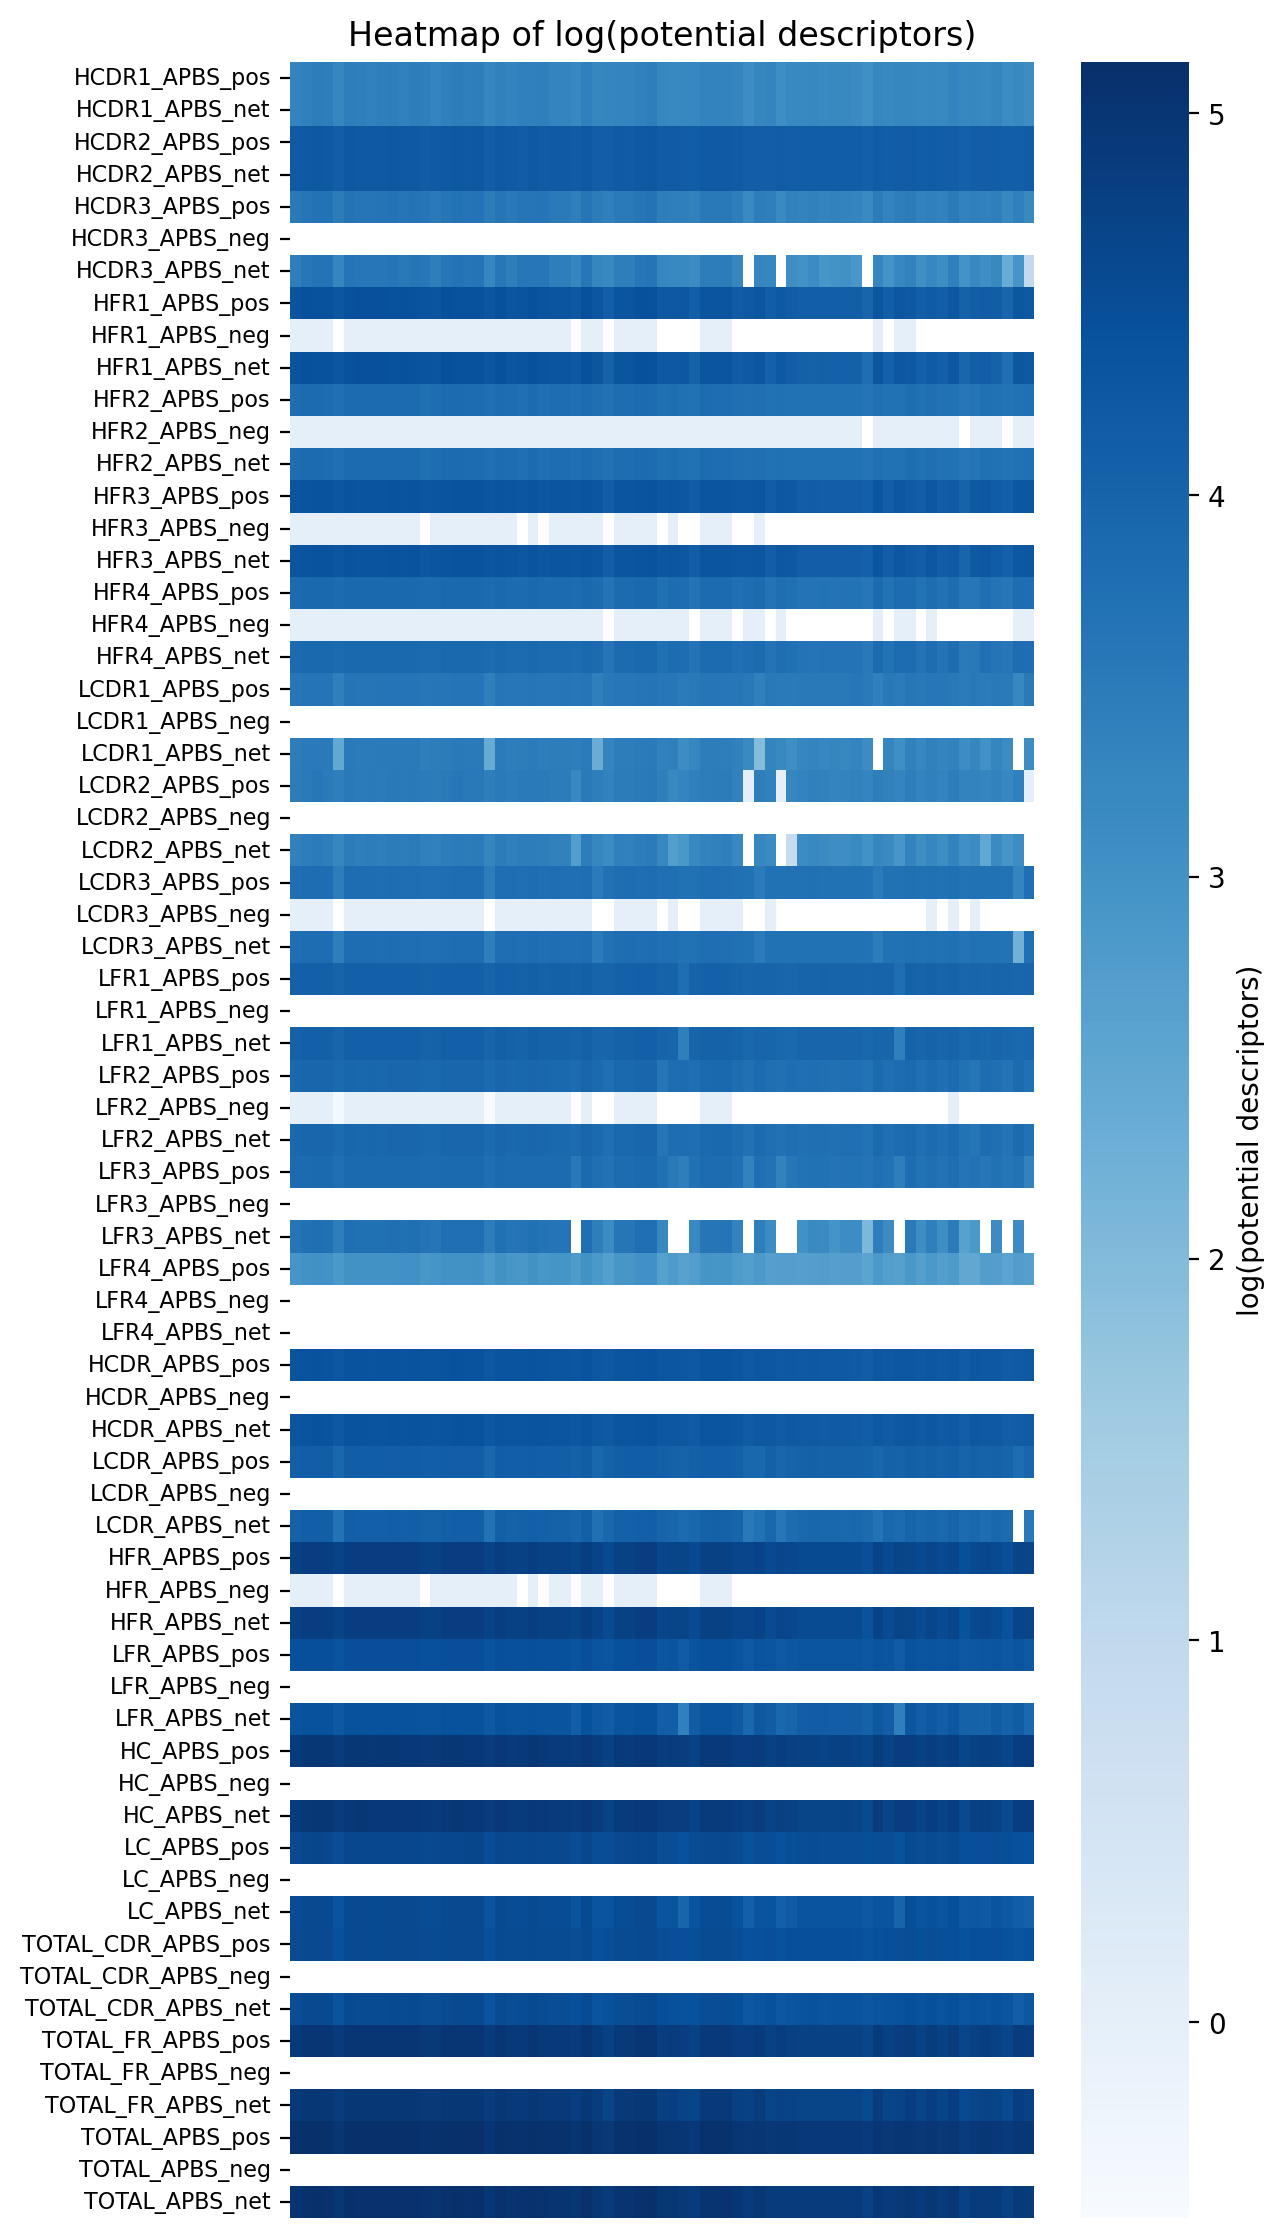

In [49]:
fig, axes = plt.subplots(1,1, figsize = (6, 14))
ax = sns.heatmap(np.log10(descriptors_df.T+1), cmap = 'Blues', cbar_kws={'label': 'log(potential descriptors)'}, ax = axes)
ax.set(xticklabels="",xticks=[], xlabel = '', title = 'Heatmap of log(potential descriptors)', mouseover=True)
ax.tick_params(axis='y', labelsize = 8)